In [1]:
from typing import Optional
import argparse
import os
import sys

import torch
import matplotlib.pyplot as plt     # type: ignore

import utilities
import model
import optimize
import pandas as pd

from utils import default_paths

import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

info_fn = os.path.join(default_paths.stim_root, 'Indep_set_info.csv')
print('\nloading image info from %s\n'%info_fn)
info_df = pd.read_csv(info_fn, index_col=0)


cuda

loading image info from /user_data/mmhender/nsd/stimuli/Indep_set_info.csv



In [3]:
fn_info = os.path.join(os.getcwd(),'vgg19_rfs_info.npy')
rfs_info = np.load(fn_info, allow_pickle=True).item()    

In [4]:
rfs_info.keys()

dict_keys(['pixel_centers', 'layer_unit_centers', 'layer_names_use', 'layer_inds'])

In [5]:
pixel_centers = rfs_info['pixel_centers']
layer_unit_centers = rfs_info['layer_unit_centers']
res_each_layer = [np.max(l)+1 for l in layer_unit_centers]
layer_names = rfs_info['layer_names_use']
layer_inds = rfs_info['layer_inds']
n_layers = len(layer_names)
n_pix = np.max(pixel_centers)+1

In [6]:
res_each_layer

[256, 128, 64, 32, 16]

In [7]:
rfs_each_layer = []
for ll, layer in enumerate(['Conv1','MaxPool1','MaxPool2','MaxPool3','MaxPool4']):
    fn_rfs = os.path.join(os.getcwd(),'vgg19_unit_rfs_%s.npy'%layer)
    rfs = np.load(fn_rfs)
    rfs_each_layer.append(rfs)
    

In [121]:

def make_square_grid_smooth(n_grid_eachside=2, n_pix=256, ramp_size=20):

    n_grid_total = n_grid_eachside**2
    grid_bounds = np.floor(np.linspace(0,n_pix, n_grid_eachside+1)).astype(int)

    grid_space = np.diff(grid_bounds)[0]
    assert(grid_space>=ramp_size*2)
    
    # define ramping edge function (squared cosine)
    xvals_ramp = np.linspace(-np.pi/2,0, ramp_size)
    ramp_vals = np.cos(xvals_ramp)**2
    # ramp_size_half = int(np.ceil(ramp_size/2))
    pad_by = 0
    
    # for the corners, use distance from corner to get round edge
    center = [0,0]
    x, y = np.meshgrid(np.arange(ramp_size), np.arange(ramp_size))
    distance = np.sqrt((x-center[0])**2 + (y-center[1])**2)
    distance /= (ramp_size-1)
    distance = -distance * np.pi/2
    distance = np.maximum(distance, -np.pi/2)
    ramp_corner = np.cos(distance)**2

    # spatial_weights_pixel = np.zeros((n_pix, n_pix, n_grid_total))
    
    # make the array with some padding on each side, this will make it easier to fill 
    # in the ramping regions.
    spatial_weights_pixel = np.zeros((n_pix+pad_by*2, n_pix+pad_by*2, n_grid_total))

    gt = -1;
    for gx in range(n_grid_eachside):
        for gy in range(n_grid_eachside):

            gt+=1
            
            xrange = [grid_bounds[gx]+ramp_size+pad_by, grid_bounds[gx+1]-ramp_size+pad_by]
            yrange = [grid_bounds[gy]+ramp_size+pad_by, grid_bounds[gy+1]-ramp_size+pad_by]

            spatial_weights_pixel[xrange[0]:xrange[1], yrange[0]:yrange[1], gt] = 1

            # add in ramp for each edge region 
            ydist = yrange[1]-yrange[0]
            ramp_tiled = np.tile(ramp_vals[:,None], [1, int(ydist)])
            spatial_weights_pixel[xrange[0]-ramp_size: xrange[0], \
                                  yrange[0]:yrange[1], gt] = \
                                    ramp_tiled
            
            ydist = yrange[1]-yrange[0]
            ramp_tiled = np.tile(np.flipud(ramp_vals[:,None]), [1, int(ydist)])
            spatial_weights_pixel[xrange[1]: xrange[1]+ramp_size, \
                                  yrange[0]:yrange[1], gt] = \
                                    ramp_tiled
            
            xdist = xrange[1]-xrange[0]
            ramp_tiled = np.tile(ramp_vals[None,:], [int(xdist),1])
            spatial_weights_pixel[xrange[0]:xrange[1], \
                                  yrange[0]-ramp_size:yrange[0], gt] = \
                                    ramp_tiled
                
            xdist = xrange[1]-xrange[0]
            ramp_tiled = np.tile(np.fliplr(ramp_vals[None,:]), [int(xdist),1])
            spatial_weights_pixel[xrange[0]:xrange[1], \
                                  yrange[1]:yrange[1]+ramp_size, gt] = \
                                    ramp_tiled

            spatial_weights_pixel[xrange[0]-ramp_size: xrange[0], 
                                  yrange[0]-ramp_size: yrange[0], gt] = \
                                    np.flipud(np.fliplr(ramp_corner))
                
            spatial_weights_pixel[xrange[0]-ramp_size: xrange[0], 
                                  yrange[1]: yrange[1]+ramp_size, gt] = \
                                    np.flipud(ramp_corner)

            spatial_weights_pixel[xrange[1]: xrange[1]+ramp_size, 
                                  yrange[0]-ramp_size: yrange[0], gt] = \
                                    np.fliplr(ramp_corner)

            spatial_weights_pixel[xrange[1]: xrange[1]+ramp_size, 
                                  yrange[1]: yrange[1]+ramp_size, gt] = \
                                    ramp_corner
             
    # un-pad the array here
    spatial_weights_pixel = spatial_weights_pixel[pad_by:pad_by+n_pix, pad_by:pad_by+n_pix,:]
    
    return spatial_weights_pixel



In [122]:
n_grid_eachside=8
n_pix=256
spatial_weights_pixel = make_square_grid_smooth(n_grid_eachside=n_grid_eachside, n_pix=n_pix)

plt.figure(figsize=(8,8))
gt = 0;
for gx in range(n_grid_eachside):
    for gy in range(n_grid_eachside):

        
        plt.subplot(n_grid_eachside, n_grid_eachside, gt+1)
        plt.pcolormesh(spatial_weights_pixel[:,:,gt])
        plt.axis('square')
        plt.gca().invert_yaxis()
        gt+=1

[  0  32  64  96 128 160 192 224 256]


ValueError: negative dimensions are not allowed

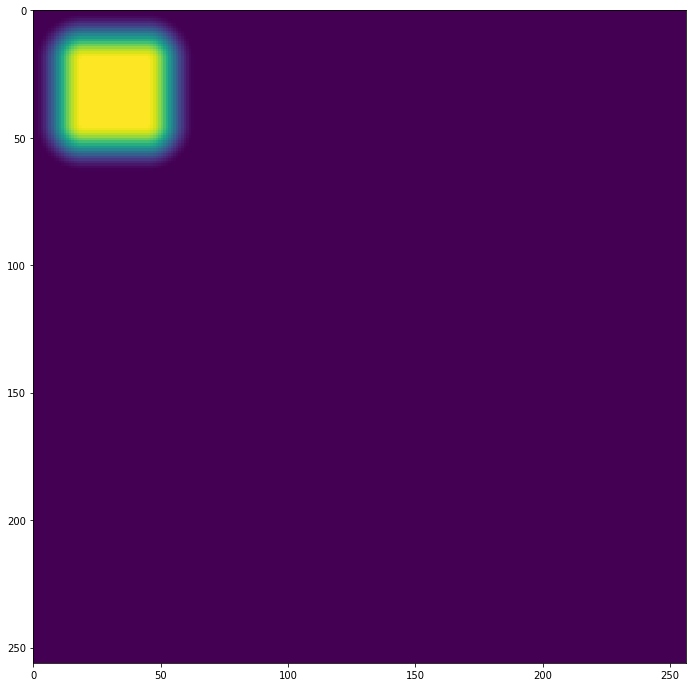

In [117]:
plt.figure(figsize=(12,12))
gt=0
plt.pcolormesh(spatial_weights_pixel[:,:,gt])
plt.axis('square')
plt.gca().invert_yaxis()

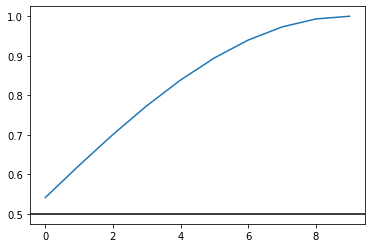

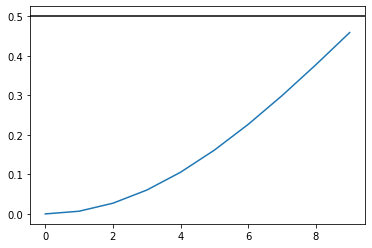

In [83]:
ramp_size=20
xvals_ramp = np.linspace(-np.pi/2,0, ramp_size)
ramp_vals = np.cos(xvals_ramp)**2
ramp_size_half = int(np.ceil(ramp_size/2))

plt.figure()
plt.plot(ramp_vals[ramp_size_half:])
plt.axhline(0.5, color='k')

plt.figure()
plt.plot(ramp_vals[0:ramp_size_half])
plt.axhline(0.5, color='k')

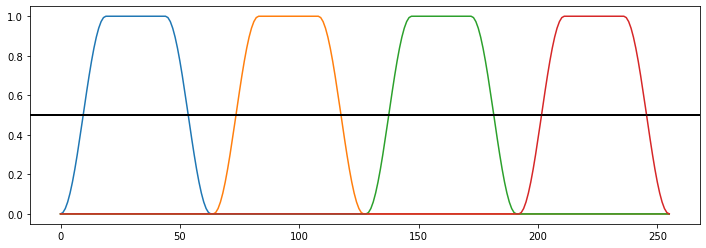

In [119]:
inds = [0,4,8,12]

plt.figure(figsize=(12,4))
    
for ii in inds:

    wts1 = spatial_weights_pixel[:,:,ii]
    
    plt.plot(wts1[:,30])
   
    plt.axhline(0.5, color='k')

/user_data/mmhender/stimuli/texture_synth_images_bettergrid/coco_000000326021/grid2x2_upto_relu1_1.png
/user_data/mmhender/stimuli/texture_synth_images_bettergrid/coco_000000326021/grid2x2_upto_pool1.png
/user_data/mmhender/stimuli/texture_synth_images_bettergrid/coco_000000326021/grid2x2_upto_pool2.png
/user_data/mmhender/stimuli/texture_synth_images_bettergrid/coco_000000326021/grid2x2_upto_pool3.png
/user_data/mmhender/stimuli/texture_synth_images_bettergrid/coco_000000326021/grid2x2_upto_pool4.png
/user_data/mmhender/stimuli/texture_synth_images_bettergrid/coco_000000326021/grid4x4_upto_relu1_1.png
/user_data/mmhender/stimuli/texture_synth_images_bettergrid/coco_000000326021/grid4x4_upto_pool1.png


FileNotFoundError: [Errno 2] No such file or directory: '/user_data/mmhender/stimuli/texture_synth_images_bettergrid/coco_000000326021/grid4x4_upto_pool1.png'

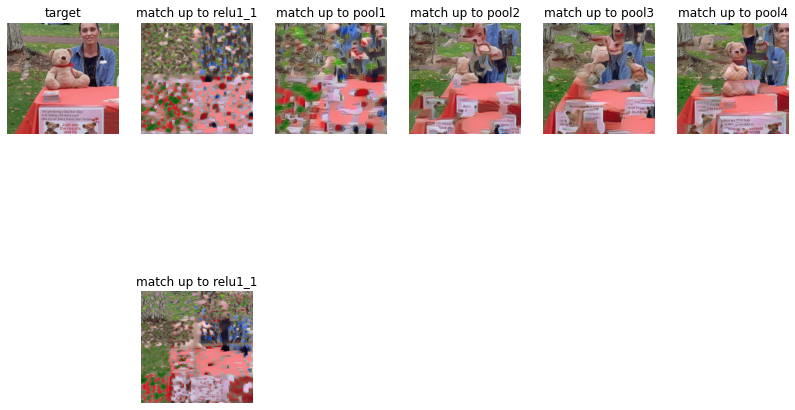

In [45]:
image_dir = os.path.join('/user_data/mmhender/stimuli/texture_synth_images_bettergrid')
plt.figure(figsize=(14,14))

ii = 0;

pi = 0;

grid_values = [2,4,8]

cocoid = '%012.f'%info_df['cocoId'][ii]
folder = os.path.join(image_dir, 'coco_%s'%cocoid)

filename_full = os.path.join(folder, 'orig.png')

im = PIL.Image.open(filename_full)

pi+=1
plt.subplot(len(grid_values), len(important_layers)+1, pi)
plt.imshow(im)
plt.axis('off')
if ii==0:
    plt.title('target')

for gg, n_grid in enumerate(grid_values):
    
    for ll in range(len(important_layers)):
          
        filename_full = os.path.join(folder, 
                                     'grid%dx%d_upto_%s.png'%(n_grid, 
                                                              n_grid, 
                                                              important_layers[ll], 
                                                             ))
        print(filename_full)
        im = PIL.Image.open(filename_full)
        
        pi+=1
        plt.subplot(len(grid_values), len(important_layers)+1, pi)
        plt.imshow(im)
        plt.axis('off')
        if ii==0:
            plt.title('match up to %s'%important_layers[ll])
       
    pi+=1

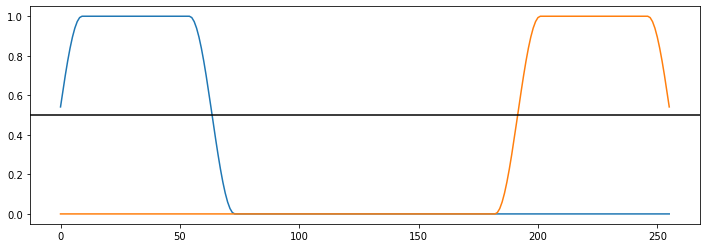

In [86]:
wts1 = spatial_weights_pixel[:,:,4]
wts2 = spatial_weights_pixel[:,:,7]

plt.figure(figsize=(12,4))
plt.plot(wts1[100,:])
plt.plot(wts2[100,:])

plt.axhline(0.5, color='k')

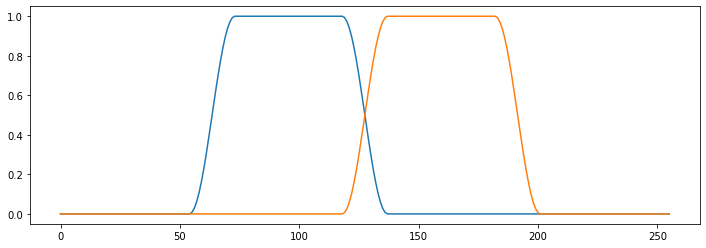

In [87]:

wts1 = spatial_weights_pixel[:,:,5]
wts2 = spatial_weights_pixel[:,:,6]

plt.figure(figsize=(12,4))
plt.plot(wts1[100,:])
plt.plot(wts2[100,:])

In [10]:
spatial_weights_pixel.shape

(256, 256, 16)

In [36]:
device = 'cpu:0'

In [37]:
overlap_each_layer = []
grid_weights = np.moveaxis(spatial_weights_pixel,[2],[0])
grid_weights = np.reshape(grid_weights, [n_grid_eachside**2, -1])
grid_weights = torch.Tensor(grid_weights).to(device)

for ll in range(n_layers):
    
    r = torch.Tensor(rfs_each_layer[ll]).to(device)
    # multiply the pixel-representation of each spatial pooling field, times
    # the pixel-representation of each unit's RF.
    # overlap is [n_grid_total x n_spat_units]
    overlap = grid_weights @ r
    # normalize each unit's overlap by the sum of the unit's RF
    overlap /= torch.sum(r, dim=0, keepdims=True)
    
    overlap_each_layer.append(overlap.detach().cpu().numpy())


In [38]:
overlap.shape

torch.Size([16, 256])

In [39]:
rfs_each_layer[ll].shape

(65536, 256)

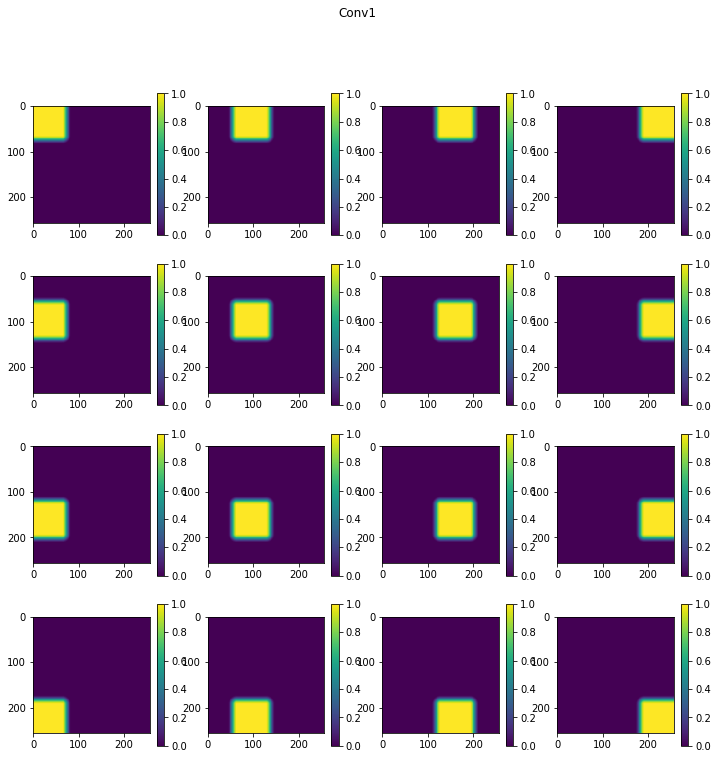

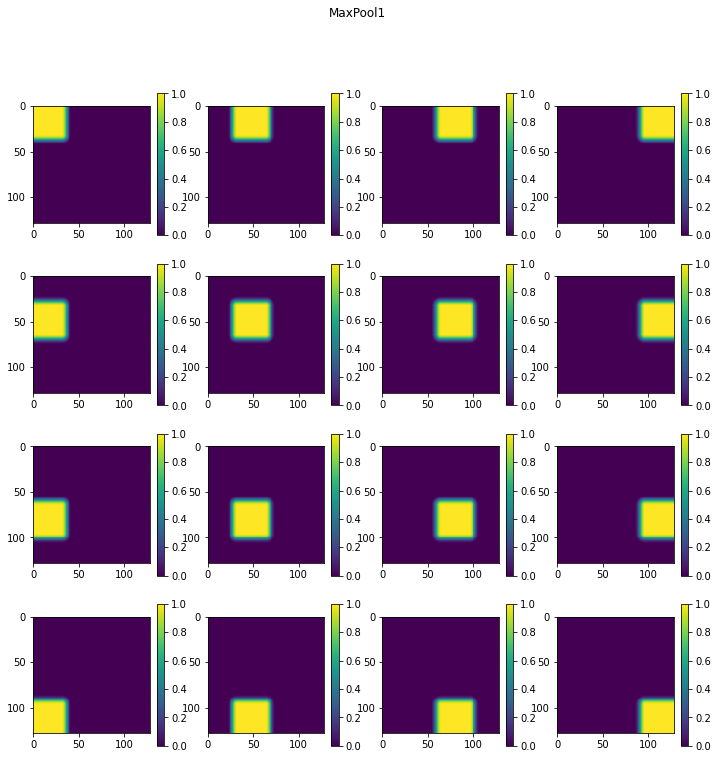

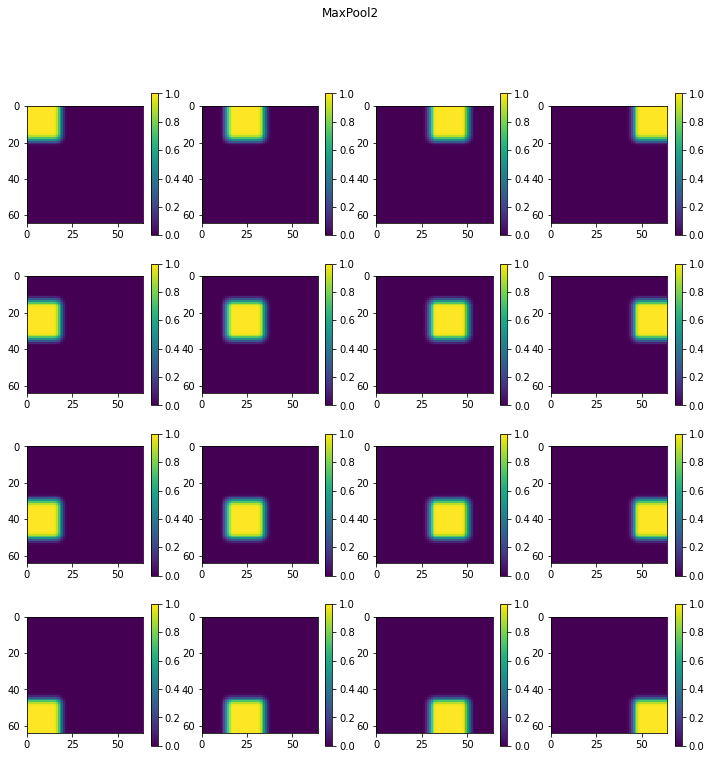

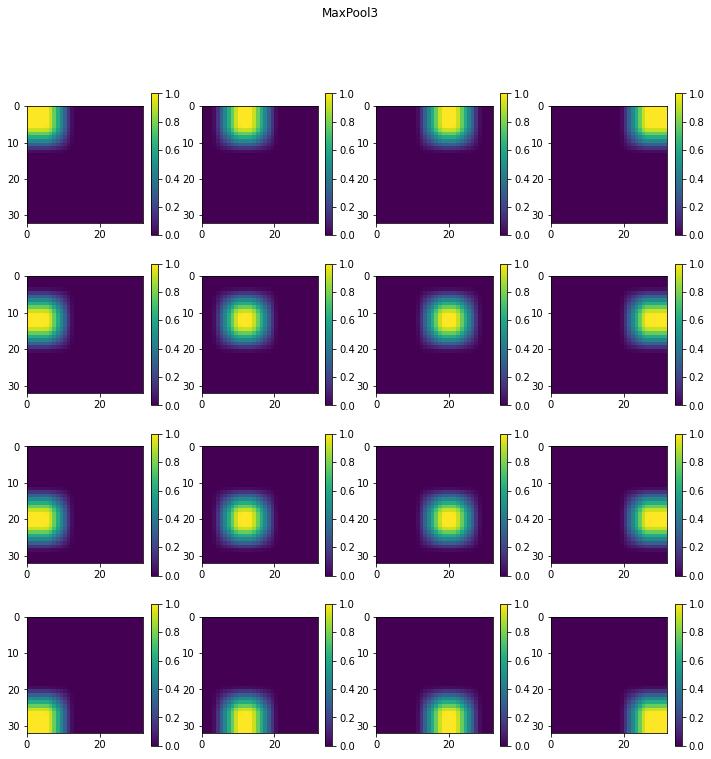

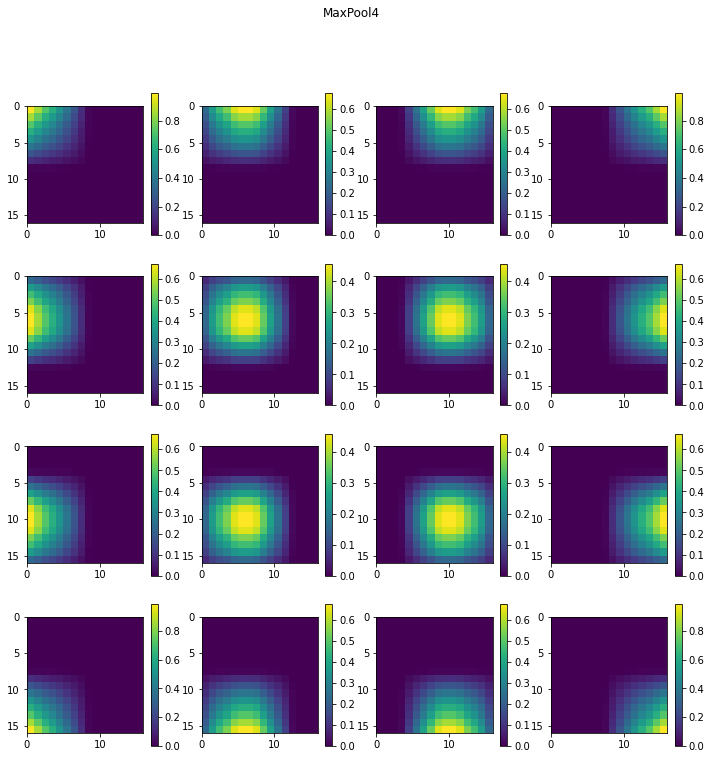

In [42]:
for ll in range(n_layers):

    overlap = overlap_each_layer[ll]
    
    res = res_each_layer[ll]

    plt.figure(figsize=(12,12))
    gt = 0;
    for gx in range(n_grid_eachside):
        for gy in range(n_grid_eachside):

            overlap_view = np.reshape(overlap[gt,:], [res,res])
            plt.subplot(n_grid_eachside, n_grid_eachside, gt+1)
            plt.pcolormesh(overlap_view)
            plt.axis('square')
            # plt.axis('off')
            plt.gca().invert_yaxis()
            gt+=1
            plt.colorbar()
            
    plt.suptitle(layer_names[ll])

In [53]:
n_grid_eachside=1;
overlap_each_layer = []
for ll in range(n_layers):
    
    fn = os.path.join(os.getcwd(),'vgg19_gridoverlap_%dx%d_%s.npy'%(n_grid_eachside, \
                                                                    n_grid_eachside, layer_names[ll]))
    print(fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_1x1_Conv1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_1x1_MaxPool1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_1x1_MaxPool2.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_1x1_MaxPool3.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_1x1_MaxPool4.npy


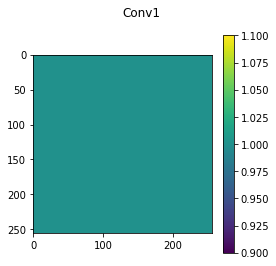

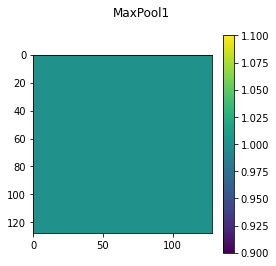

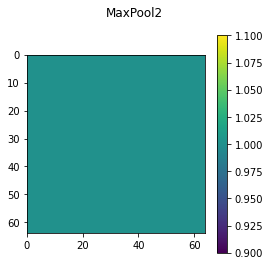

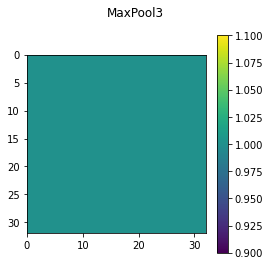

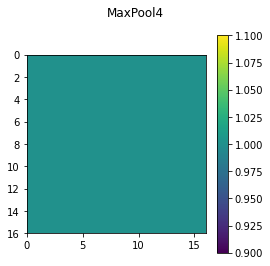

In [54]:
for ll in range(n_layers):

    overlap = overlap_each_layer[ll]
    
    res = res_each_layer[ll]

    plt.figure(figsize=(4,4))
    gt = 0;
    for gx in range(n_grid_eachside):
        for gy in range(n_grid_eachside):

            overlap_view = np.reshape(overlap[gt,:], [res,res])
            plt.subplot(n_grid_eachside, n_grid_eachside, gt+1)
            plt.pcolormesh(overlap_view)
            plt.axis('square')
            # plt.axis('off')
            plt.gca().invert_yaxis()
            gt+=1
            plt.colorbar()
            
    plt.suptitle(layer_names[ll])

In [126]:
n_grid_eachside=4;
overlap_each_layer = []
for ll in range(n_layers):
    
    fn = os.path.join(os.getcwd(),'vgg19_gridoverlap_newgrid2_%dx%d_%s.npy'%(n_grid_eachside, \
                                                                    n_grid_eachside, layer_names[ll]))
    print(fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_newgrid2_4x4_Conv1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_newgrid2_4x4_MaxPool1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_newgrid2_4x4_MaxPool2.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_newgrid2_4x4_MaxPool3.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_newgrid2_4x4_MaxPool4.npy


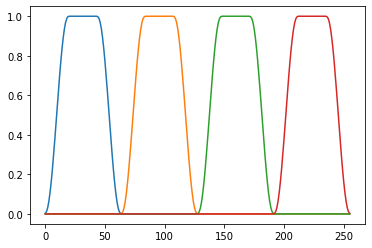

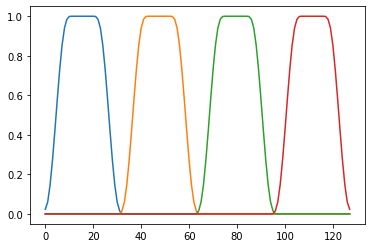

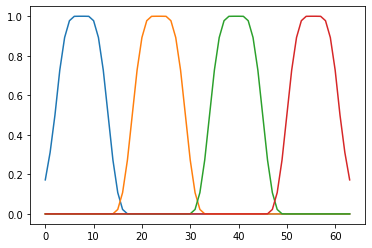

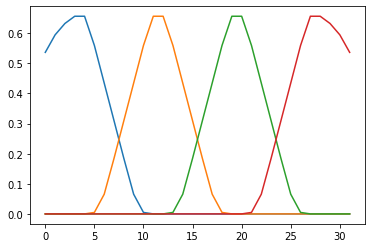

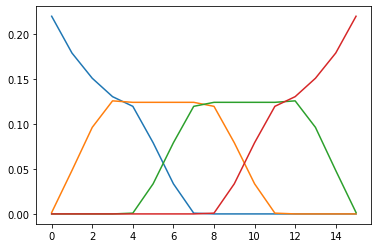

In [127]:
# centers = [60,60,24,12,6]
centers = [int(res / 8 * 3) for res in res_each_layer]

for ll in range(5):

    overlap = overlap_each_layer[ll]
    res = res_each_layer[ll]

    inds = [4,5,6,7]

    plt.figure()

    for ii in inds:

        overlap_view = np.reshape(overlap[ii,:], [res,res])

        # plt.plot(overlap_view[30,:])
        plt.plot(overlap_view[centers[ll],:])
  

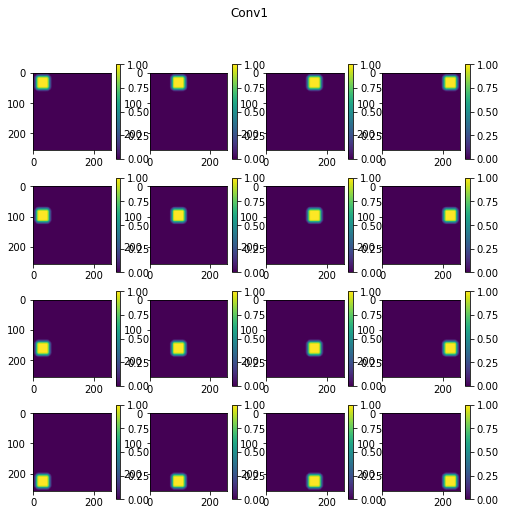

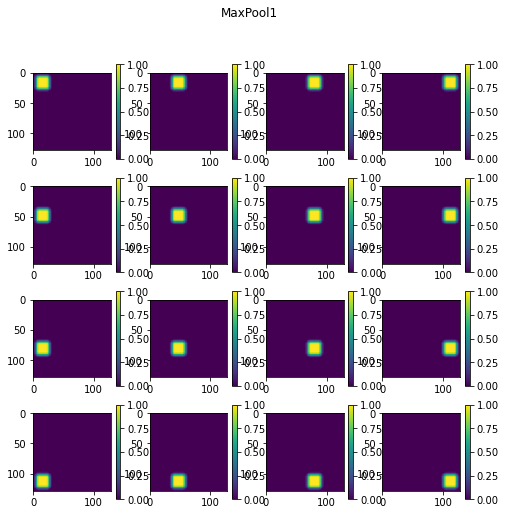

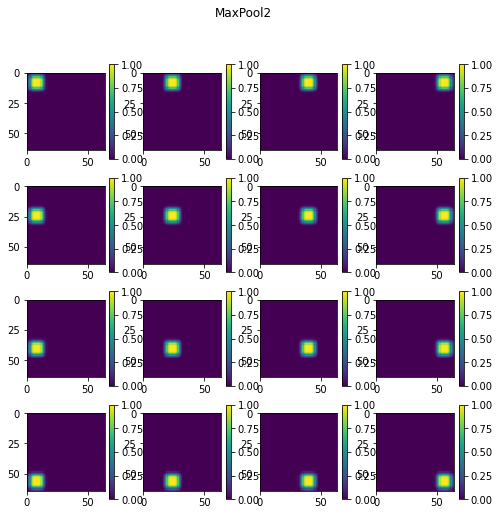

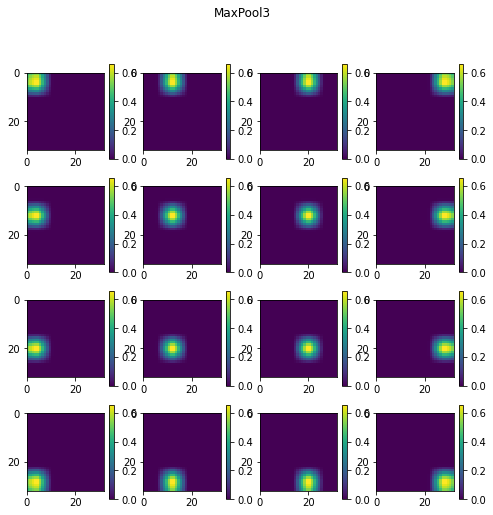

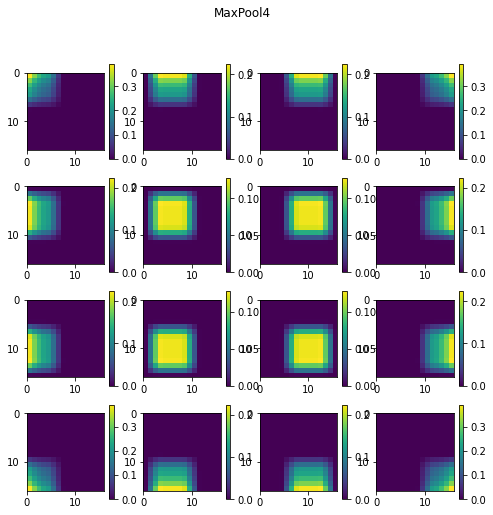

In [128]:
for ll in range(n_layers):

    overlap = overlap_each_layer[ll]
    
    res = res_each_layer[ll]

    plt.figure(figsize=(8,8))
    gt = 0;
    for gx in range(n_grid_eachside):
        for gy in range(n_grid_eachside):

            overlap_view = np.reshape(overlap[gt,:], [res,res])
            plt.subplot(n_grid_eachside, n_grid_eachside, gt+1)
            plt.pcolormesh(overlap_view)
            plt.axis('square')
            # plt.axis('off')
            plt.gca().invert_yaxis()
            gt+=1
            plt.colorbar()
            
    plt.suptitle(layer_names[ll])

In [89]:
n_grid_eachside=2;
overlap_each_layer = []
for ll in range(n_layers):
    
    fn = os.path.join(os.getcwd(),'vgg19_gridoverlap_new_%dx%d_%s.npy'%(n_grid_eachside, \
                                                                    n_grid_eachside, layer_names[ll]))
    print(fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_2x2_Conv1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_2x2_MaxPool1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_2x2_MaxPool2.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_2x2_MaxPool3.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_2x2_MaxPool4.npy


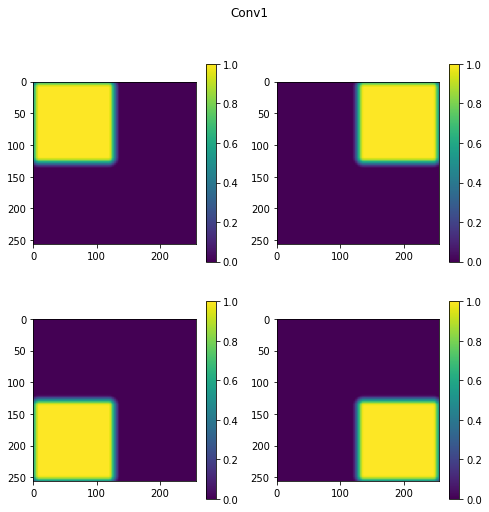

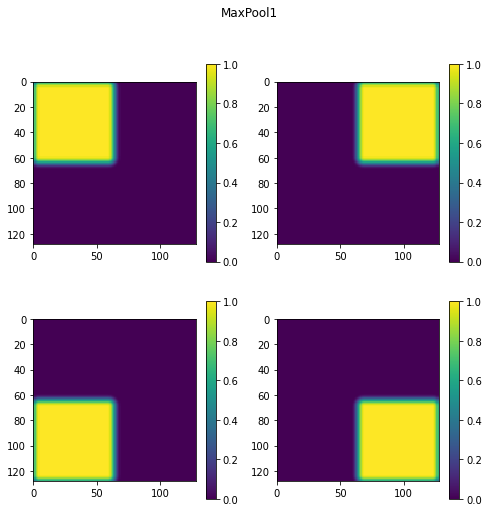

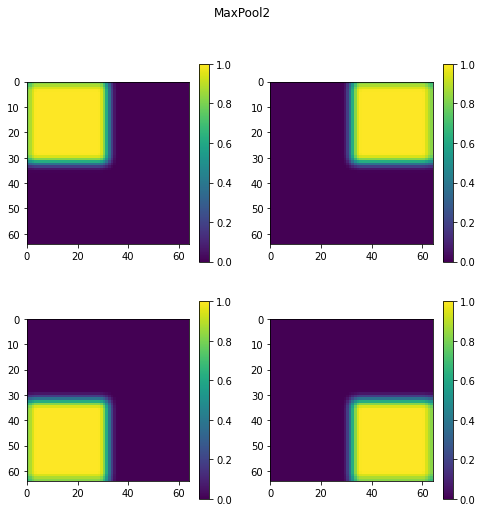

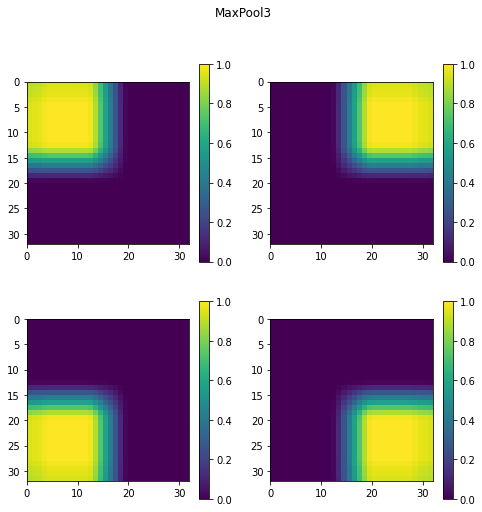

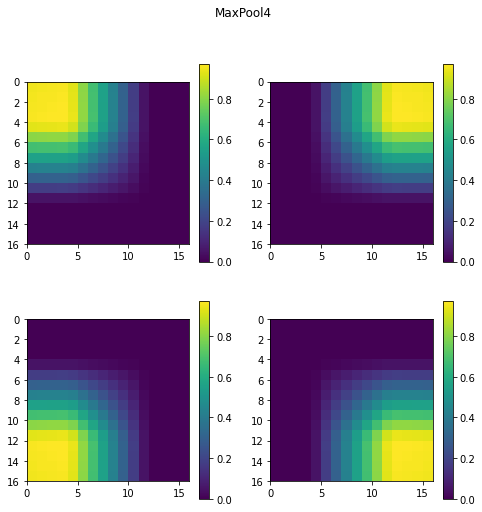

In [90]:
for ll in range(n_layers):

    overlap = overlap_each_layer[ll]
    
    res = res_each_layer[ll]

    plt.figure(figsize=(8,8))
    gt = 0;
    for gx in range(n_grid_eachside):
        for gy in range(n_grid_eachside):

            overlap_view = np.reshape(overlap[gt,:], [res,res])
            plt.subplot(n_grid_eachside, n_grid_eachside, gt+1)
            plt.pcolormesh(overlap_view)
            plt.axis('square')
            # plt.axis('off')
            plt.gca().invert_yaxis()
            gt+=1
            plt.colorbar()
            
    plt.suptitle(layer_names[ll])

In [95]:
n_grid_eachside=4;
overlap_each_layer = []
for ll in range(n_layers):
    
    fn = os.path.join(os.getcwd(),'vgg19_gridoverlap_new_%dx%d_%s.npy'%(n_grid_eachside, \
                                                                    n_grid_eachside, layer_names[ll]))
    print(fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_4x4_Conv1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_4x4_MaxPool1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_4x4_MaxPool2.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_4x4_MaxPool3.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_4x4_MaxPool4.npy


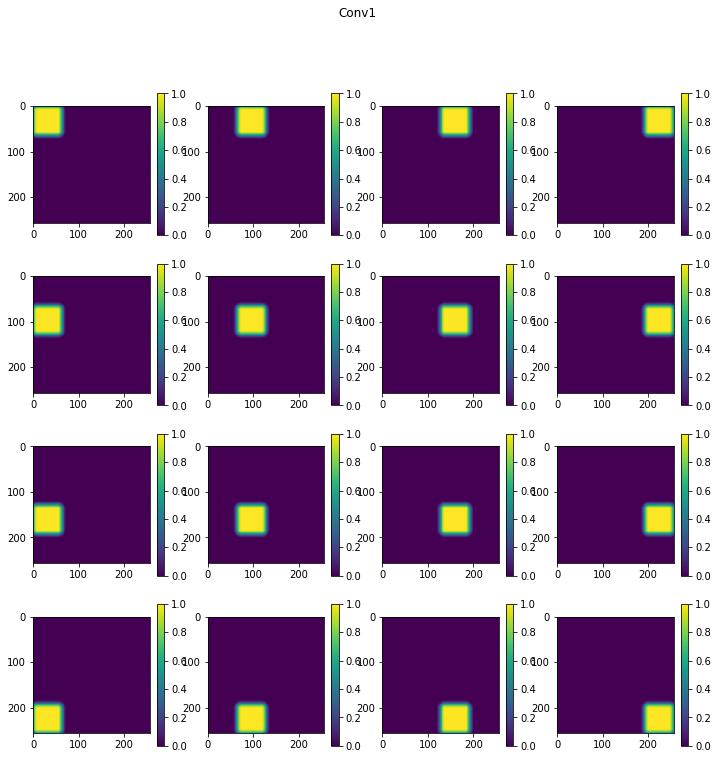

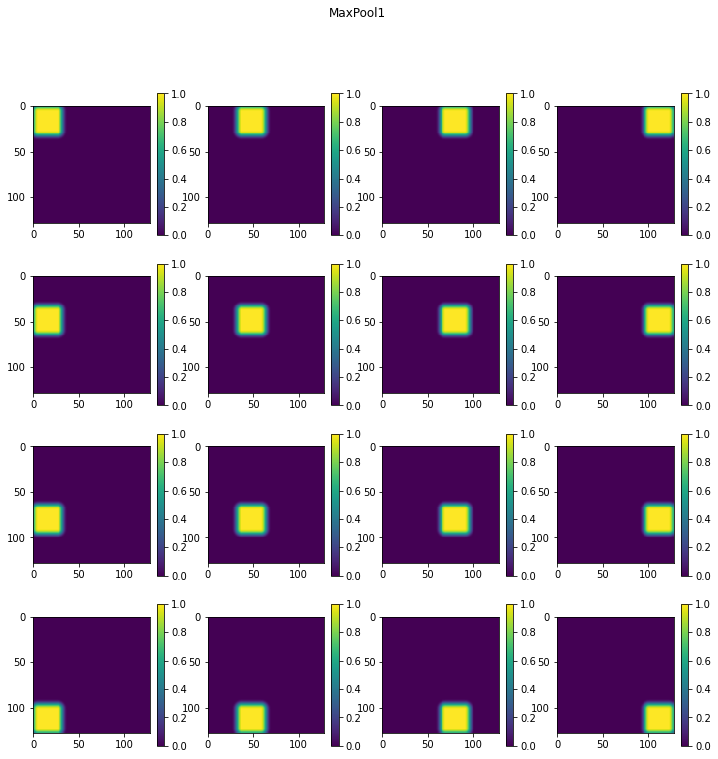

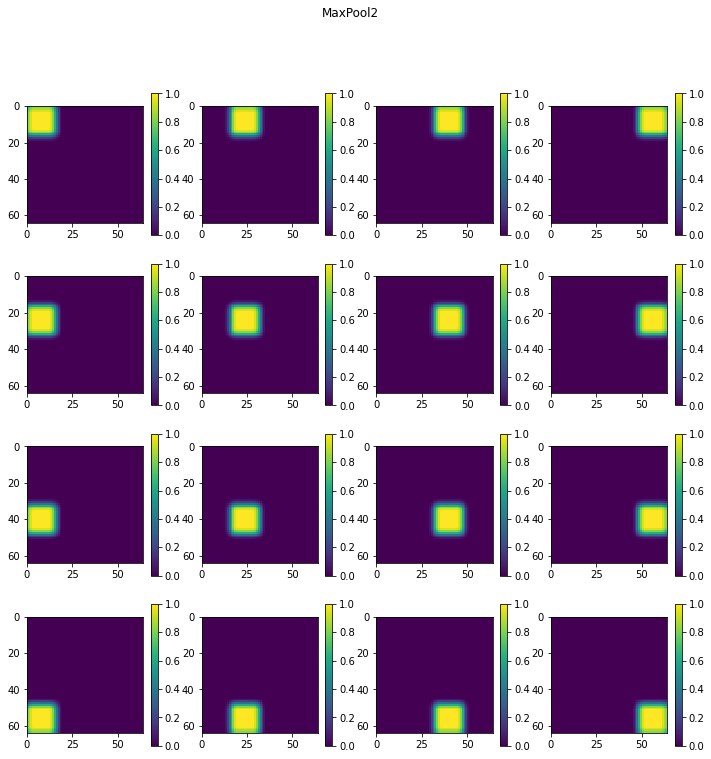

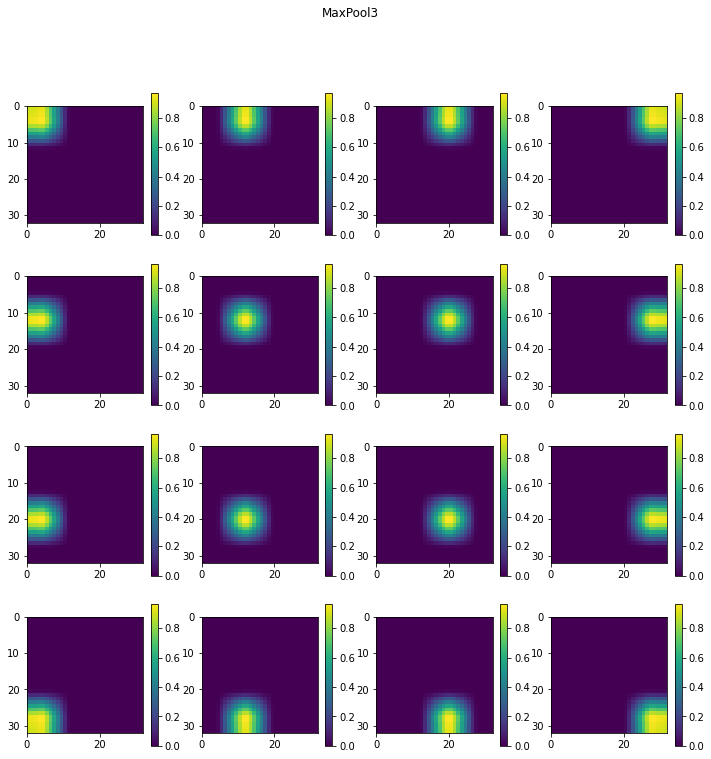

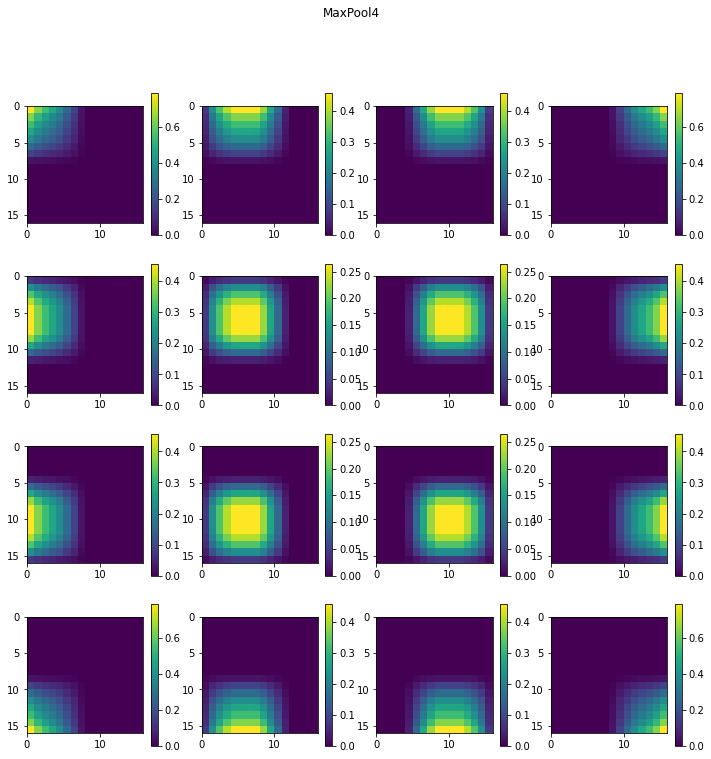

In [96]:
for ll in range(n_layers):

    overlap = overlap_each_layer[ll]
    
    res = res_each_layer[ll]

    plt.figure(figsize=(12,12))
    gt = 0;
    for gx in range(n_grid_eachside):
        for gy in range(n_grid_eachside):

            overlap_view = np.reshape(overlap[gt,:], [res,res])
            plt.subplot(n_grid_eachside, n_grid_eachside, gt+1)
            plt.pcolormesh(overlap_view)
            plt.axis('square')
            # plt.axis('off')
            plt.gca().invert_yaxis()
            gt+=1
            plt.colorbar()
            
    plt.suptitle(layer_names[ll])

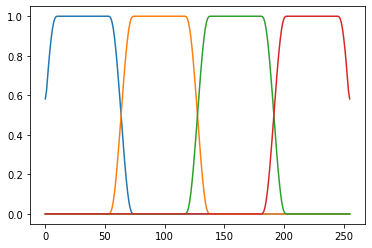

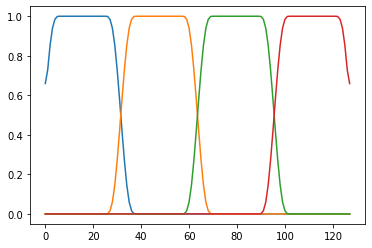

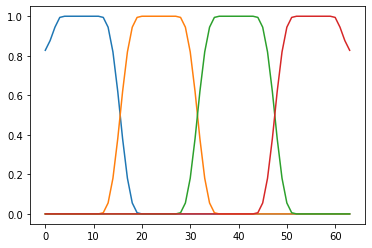

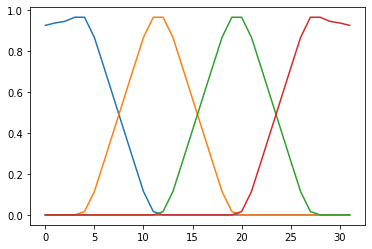

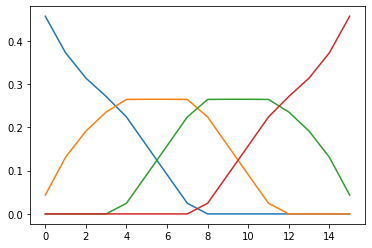

In [114]:
# centers = [60,60,24,12,6]
centers = [int(res / 8 * 3) for res in res_each_layer]

for ll in range(5):

    overlap = overlap_each_layer[ll]
    res = res_each_layer[ll]

    inds = [4,5,6,7]

    plt.figure()

    for ii in inds:

        overlap_view = np.reshape(overlap[ii,:], [res,res])

        # plt.plot(overlap_view[30,:])
        plt.plot(overlap_view[centers[ll],:])
  

In [112]:
256/8*3

96.0

In [93]:
n_grid_eachside=8;
overlap_each_layer = []
for ll in range(n_layers):
    
    fn = os.path.join(os.getcwd(),'vgg19_gridoverlap_new_%dx%d_%s.npy'%(n_grid_eachside, \
                                                                    n_grid_eachside, layer_names[ll]))
    print(fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_8x8_Conv1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_8x8_MaxPool1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_8x8_MaxPool2.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_8x8_MaxPool3.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_new_8x8_MaxPool4.npy


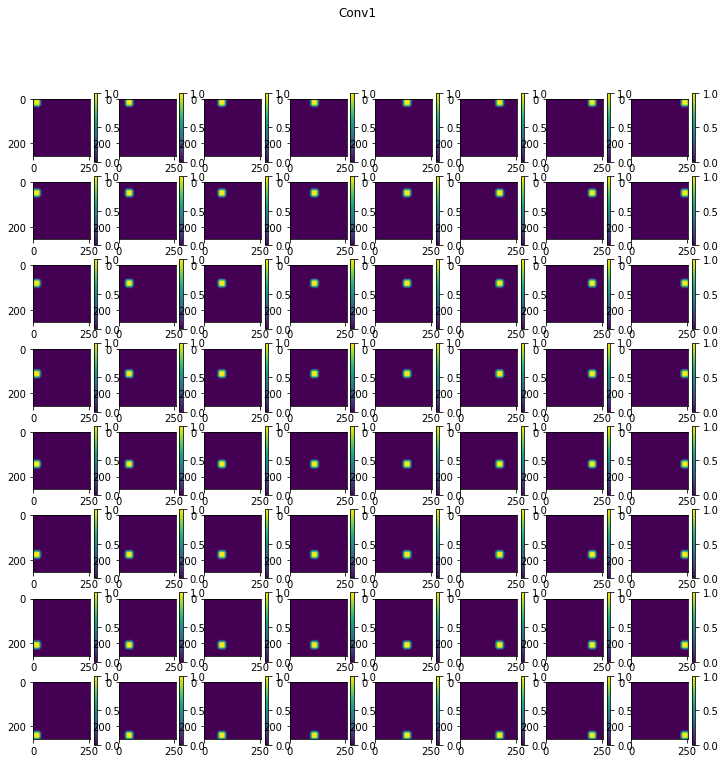

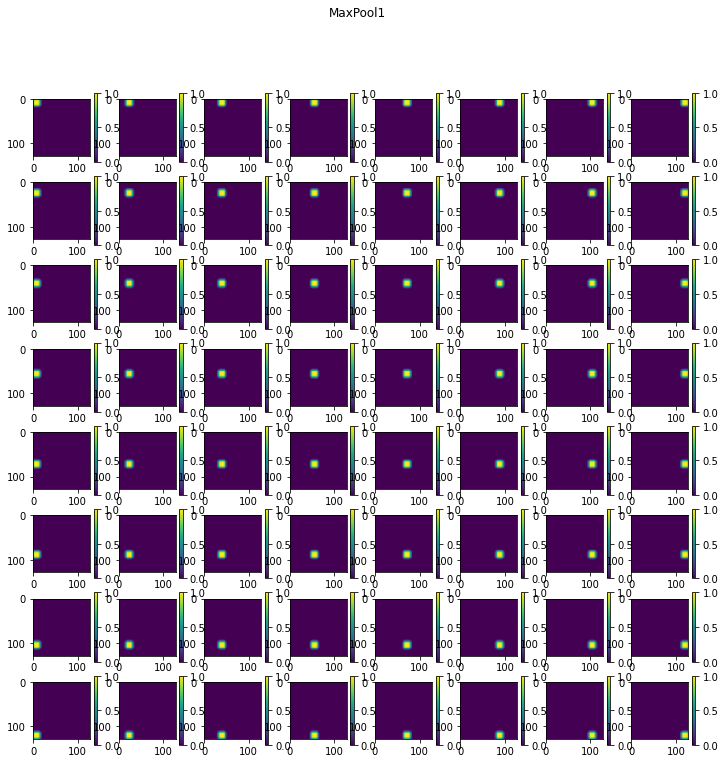

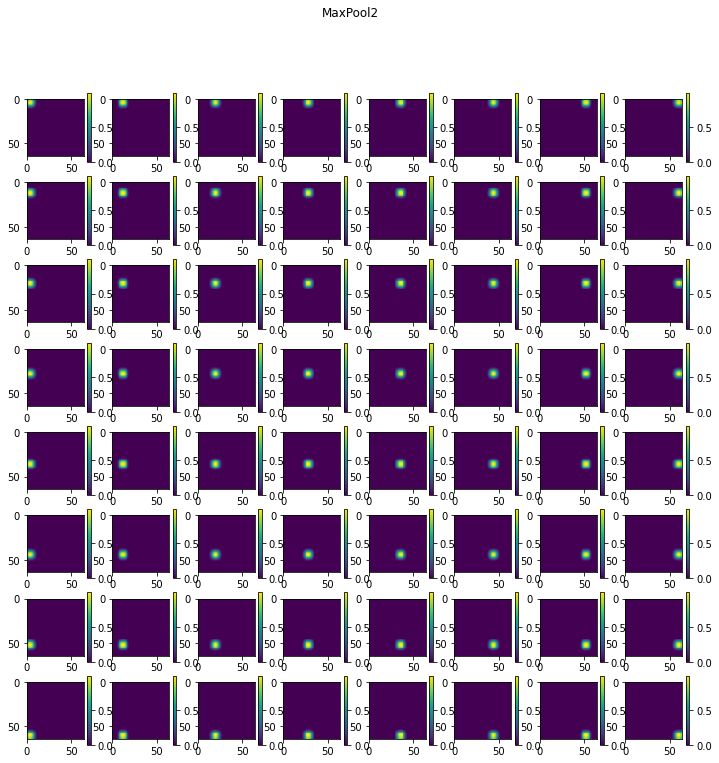

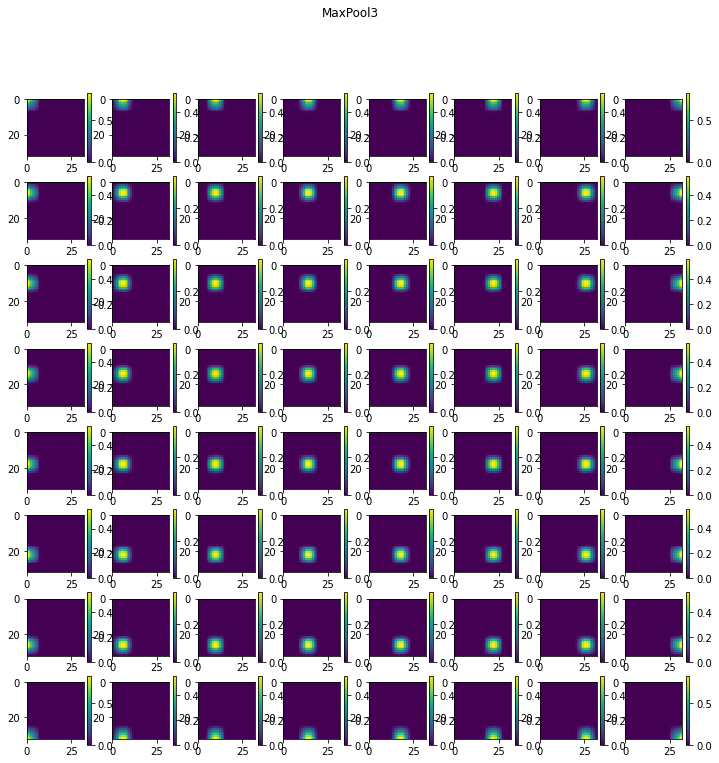

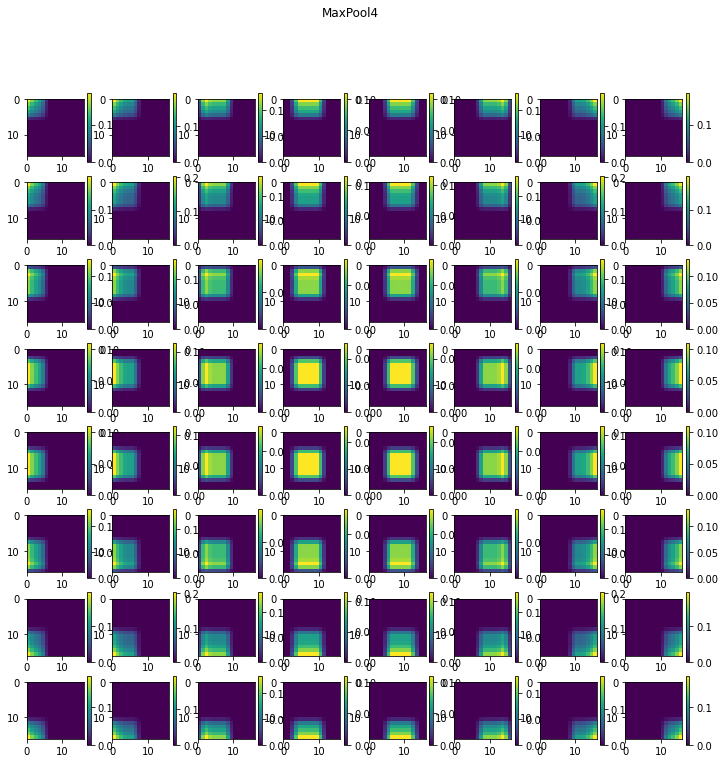

In [94]:
for ll in range(n_layers):

    overlap = overlap_each_layer[ll]
    
    res = res_each_layer[ll]

    plt.figure(figsize=(12,12))
    gt = 0;
    for gx in range(n_grid_eachside):
        for gy in range(n_grid_eachside):

            overlap_view = np.reshape(overlap[gt,:], [res,res])
            plt.subplot(n_grid_eachside, n_grid_eachside, gt+1)
            plt.pcolormesh(overlap_view)
            plt.axis('square')
            # plt.axis('off')
            plt.gca().invert_yaxis()
            gt+=1
            plt.colorbar()
            
    plt.suptitle(layer_names[ll])